# STA 141B Final Project: Data extraction and inference from the WeThePeople API
__Notebook written by Patrick Vacek__

__Team members: Graham Smith, Edie Espejo__

In all data science projects, we are working under the scheme of the data science pipeline. The pipeline, as we may know, begins with the first two steps of extracting and then transforming data. These steps make up Part I of my workbook. Part II, is inference, in which I attempt to fit a model that estimates the probability of a petition succeeding.

# Part I: Data extraction from the API

__Step 1: Import packages, set up a function to extract the live petitions__

In [11]:
#Import the packages
from fastcache import clru_cache
from datetime import datetime as dt
import requests
import numpy as np
import re
import pandas as pd
import math
np.set_printoptions(suppress=True)

I will be using clru_cache, which is a function cache, in order to cache queries. This means I need to make sure the function has as few unique parameters as possible.

In [14]:
key="ETjU0uiiXFfA9AqvBUFooOEx2OmBdeq0nquzM1k4"

#Write an API extraction function
@clru_cache(maxsize=128,typed=False)
def get_petitions(limit="1000"):
    """
    get_petitions: extract petitions from the WeThePeople API
    INPUT: limit(string): Number of petitions to return.
    OUTPUT: request_json(dict): A dictionary containing the JSON file"""
    base="https://api.whitehouse.gov/v1/petitions.json?limit="+limit+"&sortBy=date_reached_public"+"&sortOrder=desc"
    request_get=requests.get(base+"&api_key="+key)
    request_json=request_get.json()
    return(request_json)

It should be noted that we can convert a dictionary into a dataframe simply by calling Pd.DataFrame. As we can see, the petitions are stored under the "results" key. If we call pd.DataFrame on this object in the future, it will make it easier to work with.

In [15]:
get_petitions("1")["results"]

[{'body': 'Allow nation-wide concealed carry to any individual who have been granted a concealed carry license under the laws of ANY U.S. State regardless of state of residence, are not federally prohibited from possessing or receiving a firearm, and are carrying a valid government-issued photo ID.   Simply put, if a privilege such as a drivers license is valid in any state, so should a Constitutional right such as that enumerated under the 2nd Amendment. \n\nA Constitutional Right should never end at the border of one state with another; the current system only creates confusion for lawful citizens and denies them the right to defend themselves dependent upon the capricious nature of one state&#039;s individual legislation over the next.  Furthermore, it does nothing to reduce crime.',
  'created': 1488552578,
  'deadline': 1491140978,
  'id': '2515941',
  'isPublic': True,
  'isSignable': True,
  'issues': [{'id': 336, 'name': 'Government &amp; Regulatory Reform'}],
  'petition_type'

__Step 2: Cleaning the petitions data__

Our next step is converting all of the live petitions into an easy to read dataframe. To do this, we will need to create a function that handles the JSON and does a couple of string manipulation techniques to clean the data.

In [16]:
def json_to_df(json):
    #Create a dataframe from the dictionary, some values will be raw and need conversion
    pet_df=pd.DataFrame(json)
    #The issues and petition type fields need fixing
    pet_df.issues=pd.Series([", ".join([re.sub("amp;","",issue["name"]) for issue in item["issues"]]) for item in json])
    pet_df.petition_type=pd.Series(["".join([category["name"] for category in item["petition_type"]]) for item in json])
    pet_df = pet_df.drop('response', 1)
    return(pet_df)

Finally, we can run our functions to generate the data frame. We will be using the petition id for the next step. I've included an optional cell that writes the data if necessary.

In [17]:
json_petitions=get_petitions()
petitions=json_to_df(json_petitions["results"])
petitions.head()

,body,created,deadline,id,isPublic,isSignable,issues,petition_type,reachedPublic,signatureCount,signatureThreshold,signaturesNeeded,status,title,type,url
0,Allow nation-wide concealed carry to any indiv...,1488552578,1491140978,2515941,True,True,Government & Regulatory Reform,Propose a new Administration policy,1490052376,159,100000,99841,open,Enact legislation to provide nation-wide recip...,petition,https://petitions.whitehouse.gov/petition/enac...
1,Sheriff Joe Arpaio is under assault from the L...,1489776659,1492368659,2523566,True,True,Criminal Justice Reform,Take or explain a position on an issue or policy,1489951075,206,100000,99794,open,PROTECT SHERIFF JOE ARPAIO FROM UNLAWFUL PROSE...,petition,https://petitions.whitehouse.gov/petition/prot...
2,Every service person takes the following oath ...,1488994411,1491582811,2518781,True,True,Veterans & Military,Take or explain a position on an issue or policy,1489923917,225,100000,99775,open,"TO THE COMMANDER-IN-CHIEF, DONALD J. TRUMP, IN...",petition,https://petitions.whitehouse.gov/petition/comm...
3,"We, the People, demand you leave the ACA intac...",1488082991,1490671391,2512486,True,True,Health Care,Change an existing Administration policy,1489893951,167,100000,99833,open,Stop ALL Attempts to Repeal the Affordable Car...,petition,https://petitions.whitehouse.gov/petition/stop...
4,We the people of the United States of America ...,1489663926,1492255926,2522726,True,True,"Government & Regulatory Reform, Homeland Secur...",Call on Congress to act on an issue,1489843723,221,100000,99779,open,CALLING FOR THE ARREST OF BARACK H. OBAMA AND ...,petition,https://petitions.whitehouse.gov/petition/call...


In [26]:
#petitions.to_csv("petitions.csv")

At this point in the process, I handed off the data frame to Edie and Graham. I ended up labelling the petitions as "Liberal" or "Conservative" myself, which may introduce some bias. Nonetheless, additional data was acquired and compared to measure the effectiveness of the model, which may help reduce the effect of the bias.

__Step 3:__ Developing the ideal petition signatures data.

The next step in the process is acquiring and making data that I could use for the creation of my model predicting petition success. We start off by creating another function to query the signatures portion of the API. We now need to call the API by petition id, and I also introduce a new variable called offset because many signatures have a significant amount of petitions that cannot be extracted in a single query.

In [27]:
@clru_cache(maxsize=128,typed=False)
def get_signatures(pet_id,limit="1000",offset="0"):
    """
    get_signatures: Extract a set of signatures from a WeThePeople petition
    INPUT:
    pet_id(string): The petition id from the petitions section of the API
    limit(string): The number of signatures to return
    offset(string): The index at which to start on the list of petitions
    OUTPUT:
    request_json(dict): A dictionary containing the JSON file
    """
    base="https://api.whitehouse.gov/v1/petitions/"+pet_id+"/signatures.json?limit="+limit+"&offset="+offset
    request_get=requests.get(base+"&api_key="+prodkey)
    request_json=request_get.json()
    return(request_json)

As we saw in the petitions dataframe, the time variables "created" and "deadline" are not in a conventional format. They are actually in UNIX time. Before we get to extracting the signatures, we need to have functions for converting the "created" and "deadline" variables to and from UNIX time.

In [52]:
#UNIX time conversion code borrowed from stackoverflow
def convertUNIXtime(time):
    """Takes a unix time integer and converts it into a date string."""
    new_time=dt.fromtimestamp(time).strftime('%Y-%m-%d %H:%M:%S')
    return(new_time)

#Convert date back into UNIX
def convertDate(time):
    """Takes a date string and converts it into a unix time integer."""
    new_time=int(dt.strptime(time,"%Y-%m-%d %H:%M:%S").timestamp())
    return(new_time)

Now that we are equipped with the proper tools for handling the data, we can start writing functions to make repeated calls to the API for signature extraction. We want to start by writing a simple helper function, findSigs, this will call the API once at a given offset, and then return an array of the corresponding UNIX times at which the petition was signed.

In [53]:
def findSigs(petition,offset):
    """findSigs: call the signatures API once at a given offset
    INPUT:
    petition(string): The petition id
    offset(string): The index of the list of petition signatures
    OUTPUT:
    sig_times(array): An array containing UNIX time values at which the petition was signed"""
    sig_times=np.array(pd.DataFrame(get_signatures(petition,offset=offset)["results"]).created.values,dtype='int64')
    return(sig_times)

Once we have a set of signatures, we would like to make it into time series data. The makeTS function will do this for us, and it serves as a helper function for the final, generalized function afterwards. I've explained the strategy on how to convert the UNIX times to time series data within the code, step-by-step.

In [68]:
def makeTS(data,pet_idx):
    """
    makeTS: Convert the set of all signatures times into an hourly time series dataframe.
    INPUT:
    data(array): An integer array containing UNIX times of all petition signatures
    pet_idex(int): The index on the petitions data frame, used for determining the deadline.
    OUTPUT:
    ts_df(dataframe): A pandas dataframe containing the cumulative signatures, by-hour signatures, days left, and id variables.
    """
    #Find the number of time periods for the petition
    num_hours=math.ceil((np.max(data)-np.min(data))/3600)+2
    #Find the date of the first hour of the petition
    blank_bin=re.sub("[0-9]+:[0-9]+$","",convertUNIXtime(np.min(data)))+"00:00"
    #Generate the time intervals for each hour that the petition has been running
    unix_intervals=[convertDate(blank_bin)+i*3600 for i in range(1,num_hours)]
    #Create the days left variable by subtracting each unix time by hour from the deadline
    days_left=np.round((petitions.deadline[pet_idx]-unix_intervals)/(60*60*24),decimals=2)
    #Derive the cumulative signatures by hour, and difference them to obtain the hourly signature counts
    cumulative_sigs=[len(np.extract(data<=ui,data)) for ui in unix_intervals]
    sigs_diff=np.diff(np.append([0],cumulative_sigs))
    #Find the corresponding hours for the time periods and use it as an index
    hours=[convertUNIXtime(ui) for ui in unix_intervals]
    #Finally, make a data frame with all these variables
    ts_df=pd.DataFrame({"total":cumulative_sigs,"value":sigs_diff,"days_left":days_left,
                        "id":[pet_idx]*len(days_left)},index=hours)
    return(ts_df)

We can combine these two functions in order to create get_all_signatures, a function that will create a time series dataset for the signatures of every petition we have from the WeThePeopleAPI. In order to make sure I call the API a proper number of times without encountering error, I set the number of queries as $\lceil \frac{n}{1000} \rceil$, where $n$ is the number of signatures in the petition.

In [81]:
def get_all_signatures(idx):
    #Get the desired number of API calls for the 
    num=math.ceil(petitions.signatureCount[idx]/1000)
    #Make all of the calls to the API
    sigtimes_list=[findSigs(petitions.id[idx],str(1000*i)) for i in range(num)]
    #Finally, concatenate the list of signature times into an array, and then convert it to a time series dataframe.
    signatures_ts=np.concatenate(sigtimes_list)
    ts_df=makeTS(signatures_ts,idx)
    return(ts_df)

We can finally performt he data extraction, simply by calling a list comprehension with the final function, and then using pd.concat to make the list of dataframes into a single dataframe. 

__Warning:__ The operation to extract all of the data is very slow, and may take up to 30 minutes. It is meant to be completed once. I recommend reading in the csv from github instead.

In [82]:
petitions_timeseries=pd.concat([get_all_signatures(i) for i in petitions.index])

Finally, here is some code to save the csv, it is commented out. Now that we have the essential data, we can move onto the second part of the project.

In [8]:
#petitions_timeseries.to_csv("petitionsTS.csv")
#Read in the data from GitHub instead
petitions_timeseries=pd.read_csv("https://raw.githubusercontent.com/palautatan/project141b/master/data/petitionsTS.csv",index_col="Unnamed: 0")

# Part II: Building a prediction model for petition success

For the second step of my work on this project, I decided to attempt some statistical modeling of the time series data. My target parameter to estimate was the probability $\hat{\pi}$ that a petition would pass. The probability is conditioned a set of variables $X_{1},...,X_{p}$ that I attempted to discover. Given that we are attempting to estimate a binary outcome variable, with continuous predictors, indicated to me that using logistic regression would be a good choice.

__Step 1:__ Find out how many petitions passed, select the useful data, and model the outcome variable.

We can derive the outcome variable by finding which petitions exceeded 100,000 signatures. We will begin by finding which petitions were successful.

In [18]:
successful_petitions=np.unique(petitions_timeseries[(petitions_timeseries.total>=100000)&(petitions_timeseries.days_left>=0)].id)

In [19]:
petitions[np.in1d(petitions.index,successful_petitions)==True].title

277    The United States must stop investing in fossi...
292    Boost the American Economy through Climate Action
296                     Repeal the 1986 Hughes amendment
297                                       Repeal the NFA
298    Donald Trump:  Resign as President of the Unit...
299    Let American Farmers Grow Hemp Once Again to C...
300    Divest or put in a blind trust all of the Pres...
Name: title, dtype: object

Unfortunately, we are only working with 7 successful petitions, this may cause some issues because we are trying to predict a rare event, given our data. Nonetheless, we can "extend out" the number of successes by mapping the value to all observations of a successful petition. We can find this result by creating the outcome variable. The result can be done with some simple numpy tricks.

In [20]:
passed=np.in1d(petitions_timeseries.id.values,successful_petitions).astype(int)
petitions_timeseries["passed"]=passed

In [400]:
def diff_signatures(pet_id):
    sigs_diff=pd.DataFrame(np.concatenate((np.zeros(24),petitions_model[petitions_model.id==pet_id].value))).diff(24).loc[24:]
    return(sigs_diff)

Before we should derive the count of data entries where the petition eventually passed 100,000 signatures, we should subset out any data that might not be useful to us. We are trying to look at petitions *before* they reach 100,000 signatures, so we'll only consider when the total signatures is less than that value. We also don't want any petitions that have *expired*, so we'll only consider cases where the number of days is at least 0.

In [552]:
petitions_model=petitions_timeseries[(petitions_timeseries.total<100000)&(petitions_timeseries.days_left>=0)]

In [553]:
def ma_signatures(pet_id):
    subset=petitions_model[petitions_model.id==pet_id]
    if(len(subset)<24):
        return(pd.DataFrame(subset.value))
    sigs_diff=pd.DataFrame(petitions_model[petitions_model.id==pet_id].value).rolling(24).mean().rename(columns={0:"value"})
    return(sigs_diff)

In [404]:
sigs_ma=pd.concat([ma_signatures(pet_id) for pet_id in petitions.index]).set_index(petitions_model.index)

In [233]:
sigs_diff=pd.concat([diff_signatures(pet_id) for pet_id in petitions.index]).set_index(petitions_model.index)

In [557]:
petitions_model.is_copy=False
petitions_model["day_lag"]=sigs_diff.values
petitions_model["moving_avg"]=sigs_ma.values

Now we can derive the counts of successes and failures:

In [238]:
petitions_model.groupby("passed").id.count()

passed
0    190376
1      1524
Name: id, dtype: int64

Although the ratio may be potentially smaller, having a decent amount of variables having the "passed" value will help with your model selection process.

__Step 2:__ Perform data exploration before we attempt to fit the model.\

Before we attempt to fit the model, let's examine how some of the potential variables are related. I have five plots below examining their relationships.

In [239]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = (10.0, 7.0)
from pandas.tools.plotting import scatter_matrix

__Examine the estimated probability across key variables using hexbinning__

__Relationship between days left and total signatures__

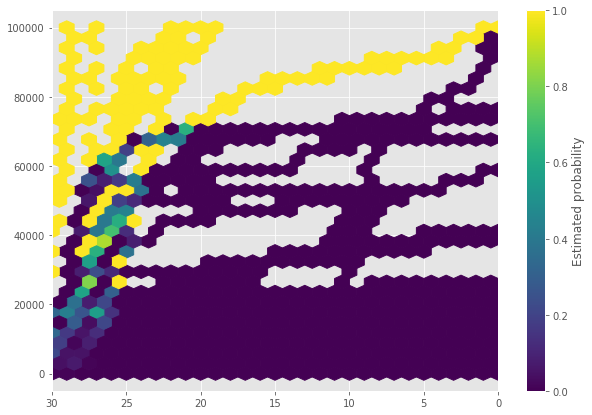

In [41]:
plt.hexbin(petitions_model.days_left, petitions_model.total, C=petitions_model.passed, gridsize=30, bins=None)
plt.xlim(30,0)
cb = plt.colorbar()
cb.set_label("Estimated probability")
plt.show()   

__Relationship between days left and signatures per hour__

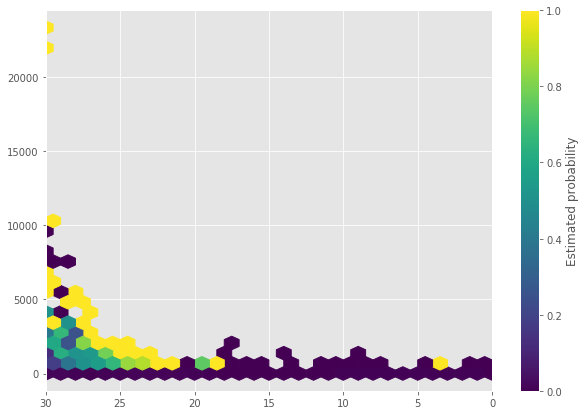

In [412]:
plt.hexbin(petitions_model.days_left, petitions_model.value, C=petitions_model.passed, gridsize=30, bins=None)
plt.xlim(30,0)
cb = plt.colorbar()
cb.set_label("Estimated probability")
plt.show()   

__Relationship between total signatures and signatures per hour__

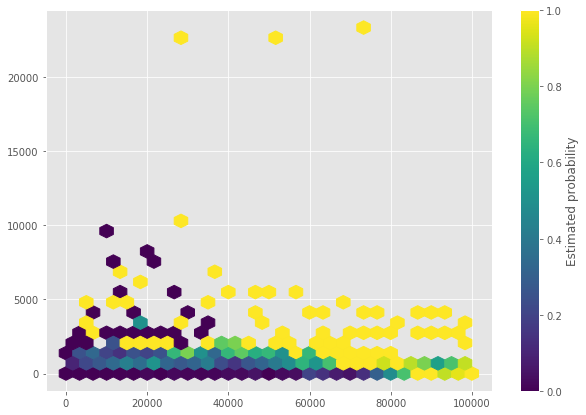

In [411]:
plt.hexbin(petitions_model.total, petitions_model.value, C=petitions_model.passed, gridsize=30, bins=None)
cb = plt.colorbar()
cb.set_label("Estimated probability")
plt.show()   

__Step 3:__ Fitting a logistic regression model

For building a logistic model, I decided to follow some of the code from this page: http://nbviewer.jupyter.org/gist/justmarkham/6d5c061ca5aee67c4316471f8c2ae976

In [524]:
from patsy import dmatrices
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import math

In [554]:
def buildModel(features):
    y, X = dmatrices('passed ~ days_left + total '+features, petitions_model, return_type = 'dataframe')
    y=np.ravel(y)
    model=LogisticRegression()
    model.fit(X,y)
    probs=model.predict_proba(X)[:,1]
    if(len(probs)<len(petitions_model)):
        rss=np.sum((probs-petitions_model[np.isnan(petitions_model.moving_avg)==False].passed.values)**2)
    else:
        rss=np.sum((probs-petitions_model.passed.values)**2)
    return([rss,probs])

In [558]:
models_list=["+ moving_avg","+ day_lag","+ value"]
models=[buildModel(feat) for feat in models_list]

In [546]:
model_table=pd.DataFrame([["days_left + total "+m for m in models_list],[m[0] for m in models]]).T
model_table.rename(columns={0:"model",1:"rss"})

,model,rss
0,days_left + total + moving_avg,604.694
1,days_left + total + day_lag,781.646
2,days_left + total + value,720.702


In [572]:
petitions_model["raw value"]=models[2][1]
petitions_model["differencing"]=models[1][1]
petitions_non_na=petitions_model[np.isnan(petitions_model.moving_avg)==False]
petitions_non_na.is_copy=False
petitions_non_na["moving average"]=models[0][1]

[]

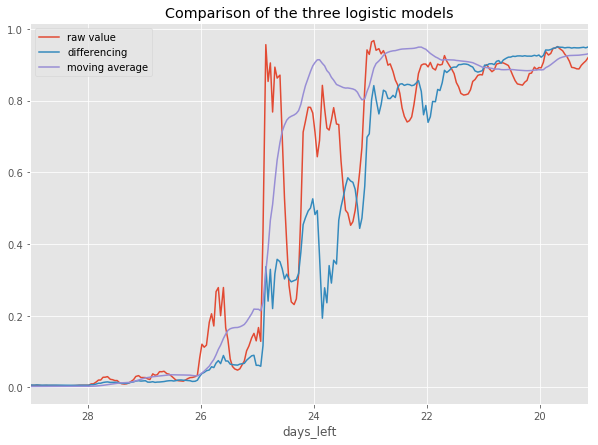

In [573]:
petitions_non_na[petitions_non_na.id==296].plot(x="days_left",y=["raw value","differencing","moving average"])
plt.title("Comparison of the three logistic models")
plt.plot()